In [1]:
library(magrittr)
library(tidyverse)
library(cowplot)
library(UpSetR)

palette <- c('HSIC Lasso' = '#c994c7', 
             'Block HSIC Lasso, B = 50' = '#df65b0',
             'Block HSIC Lasso, B = 20' = '#e7298a', 
             'Block HSIC Lasso, B = 10' = '#ce1256',
             'Block HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 
             'Raw' = 'gray70')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Supplementary figure 1

In [2]:
summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    methods <- c('HSIC Lasso', 'mRMR', 
             'Block HSIC Lasso, B = 10', 'LARS',
             'Block HSIC Lasso, B = 5', 'Raw')
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- summarize_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- summarize_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- summarize_benchmark('../results/asu/warpPIE10P_prediction.tsv')

prediction_img <- bind_rows(pixraw10P, warpAR10P, orlraws10P, warpPIE10P)

face_recognition <- prediction_img %>%
    filter(model != 'Raw') %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_img, model == 'Raw'), 
                   aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Algorithm') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 2) +
        guides(color = guide_legend(nrow = 3, byrow = TRUE))

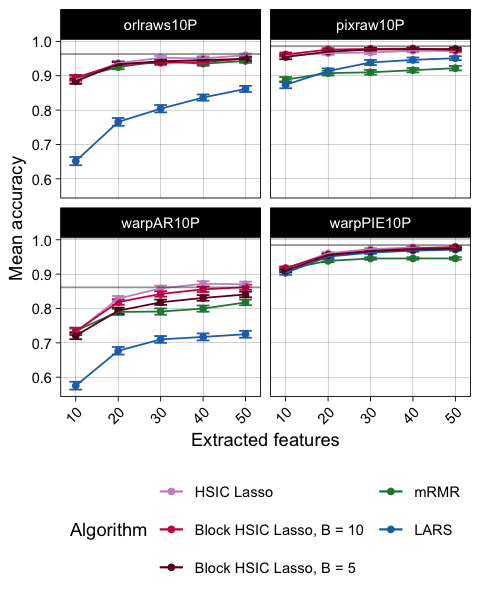

In [3]:
ggsave('img/supp_figure_1.pdf', face_recognition, width = 4, height = 5)
options(repr.plot.width = 4, repr.plot.height = 5)
face_recognition

# Supplementary figure 2

In [4]:
options(repr.plot.width=4, repr.plot.height=3.5)

gwas_exps <- c('t1d', 't2d', 'ra')

lapply(gwas_exps, function(pheno) {
    
    results <- '../results/gwas/' 
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=10_SELECT=50_M=3_B=20.txt'), 
                     col_names = F, col_types = 'c') %>%
        head(10) %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        filter(SNP %in% selected & P < (.05 / (4 * n()))) %>%
        mutate(TEST = ifelse(TEST == 'GENO', 'Genotypic', TEST),
               TEST = ifelse(TEST == 'DOM', 'Dominance', TEST),
               TEST = ifelse(TEST == 'TREND', 'Trend', TEST),
               TEST = ifelse(TEST == 'REC', 'Recessive', TEST),
               TEST = ifelse(TEST == 'ALLELIC', 'Allelic', TEST)) %>%
        select(SNP, TEST)
    
    gwas <- fromList(split(gwas$SNP, gwas$TEST))
    
    pdf(file=paste0('img/supp_figure_2_', pheno , '.pdf'), onefile=FALSE,
        width=4, height=3.5)
    
    upset(gwas, order.by = "freq", 
          sets.x.label = 'Block HSIC Lasso overlap', 
          mainbar.y.label = 'Intersection size', 
          mb.ratio = c(.6, .4), 
          point.size = 3.5, line.size = 1.2)
    
    dev.off()

})

[[1]]
pdf 
  2 

[[2]]
pdf 
  2 

[[3]]
pdf 
  2